In [2]:
pip install keras_efficientnets

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install efficientnet

     |████████████████████████████████| 50 kB 532 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install Keras-Applications

Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [6]:
from keras import applications
from keras import callbacks
import pandas as pd
import numpy as np
import glob
import os
import keras
from keras.layers import Input, Dense, Dropout, Activation, GlobalAveragePooling2D,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import efficientnet.keras as efn
from keras.models import Sequential
import itertools
from sklearn.metrics import confusion_matrix

In [7]:
# Path to get Dataset
train_path = '/kaggle/input/fire-no-fire/Fire-vs-NoFire/Training/Training'
test_path = '/kaggle/input/fire-no-fire/Fire-vs-NoFire/Test/Test'

# Exploratory Data Analysis

In [8]:
# Total Number of images from Trin/Test Dataset
train_image_names = glob.glob('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Training/Training/*/*.jpg')
test_image_names = glob.glob('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Test/Test/*/*.jpg')

print("Total number of training images: ", len(train_image_names))
print("Total number of Test images: ", len(test_image_names))

Total number of training images:  39375
Total number of training images:  8617


In [7]:
# Classes of Training Dataset
NUM_CLASSES = len(next(os.walk(train_path))[1])

print("Number of classes: {}".format(NUM_CLASSES))

Number of classes: 2


In [8]:
# Count Number of images of two claesses from Training Dataset
train_image_names = glob.glob('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Training/Training/*/*.jpg')
train_Fire_image_names = glob.glob('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Training/Training/Fire/*.jpg')
train_noFire_image_names = glob.glob('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Training/Training/No_Fire/*.jpg')

print("Total number of training images: ", len(train_image_names))
print("number of Fire images: ", len(train_Fire_image_names))
print("number of No Fire images: ", len(train_noFire_image_names))

Total number of training images:  39375
number of Fire images:  25018
number of No Fire images:  14357


In [9]:
# Count Number of images of two claesses from Test Dataset
test_image_names = glob.glob('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Test/Test/*/*.jpg')
test_Fire_image_names = glob.glob('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Test/Test/Fire/*.jpg')
test_noFire_image_names = glob.glob('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Test/Test/No_Fire/*.jpg')

print("Total number of training images: ", len(test_image_names))
print("number of Fire images: ", len(test_Fire_image_names))
print("number of No Fire images: ", len(test_noFire_image_names))

Total number of training images:  8617
number of Fire images:  5137
number of No Fire images:  3480


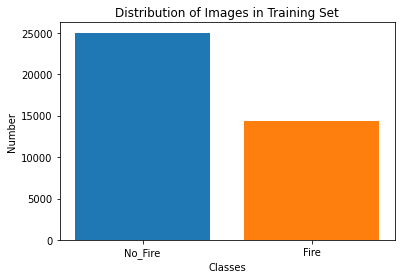

In [10]:
# Distribution of Images in Training Set
plt.bar(os.listdir('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Training/Training')[0], len(train_Fire_image_names))
plt.bar(os.listdir('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Training/Training/')[1], len(train_noFire_image_names))
plt.xlabel("Classes")
plt.ylabel("Number")
plt.title("Distribution of Images in Training Set")
plt.show()

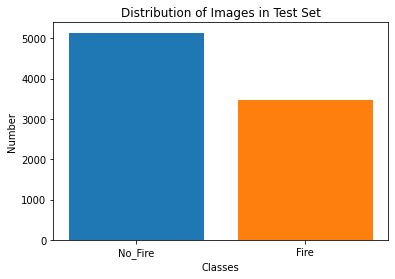

In [11]:
# Distribution of Images in Test Set
plt.bar(os.listdir('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Test/Test')[0], len(test_Fire_image_names))
plt.bar(os.listdir('/kaggle/input/fire-no-fire/Fire-vs-NoFire/Test/Test')[1], len(test_noFire_image_names))
plt.xlabel("Classes")
plt.ylabel("Number")
plt.title("Distribution of Images in Test Set")
plt.show()

In [10]:
IMG_WIDTH, IMG_HEIGHT = 224,224
channels = 3
BATCH_SIZE = 32

input_shape = (IMG_HEIGHT, IMG_WIDTH, channels)

# Using convolutional Neural Network Model

In [11]:
# ImageDataGenerator for training pictures with data augmentation
train_datagen = ImageDataGenerator (
            rescale=1./255,
            validation_split = 0.2, # Split into Train/Validation
           )

In [12]:
# Train/Validation Generator
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='binary',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_path, 
                                                         batch_size=BATCH_SIZE, 
                                                         class_mode='binary', 
                                                         subset='validation')

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.


{'Fire': 0, 'No_Fire': 1}
{'Fire': 0, 'No_Fire': 1}


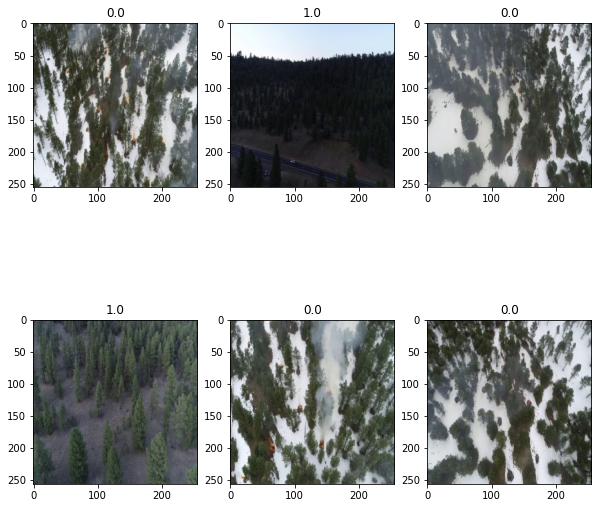

In [13]:
# Plot the random images
fig , axs = plt.subplots(2,3 ,figsize = (10,10))
axs[0][0].imshow(train_generator[0][0][12])
axs[0][0].set_title(train_generator[0][1][12])
axs[0][1].imshow(train_generator[0][0][1])
axs[0][1].set_title(train_generator[0][1][1])
axs[0][2].imshow(train_generator[0][0][14])
axs[0][2].set_title(train_generator[0][1][14])
axs[1][0].imshow(train_generator[0][0][17])
axs[1][0].set_title(train_generator[0][1][17])
axs[1][1].imshow(train_generator[0][0][19])
axs[1][1].set_title(train_generator[0][1][19])
axs[1][2].imshow(train_generator[0][0][3])
axs[1][2].set_title(train_generator[0][1][3])

#Title of 0.0 refers to Fire
#1.0 refers to NoFire
print(train_generator.class_indices)
print(validation_generator.class_indices)

In [14]:
checkpointer = ModelCheckpoint(filepath='CNN.h5', verbose=1, save_best_only=True)

In [20]:
# Model Structure
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [21]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 85, 85, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 42, 42, 64)       

In [23]:
# Compilation of model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [24]:
train_steps = train_generator.n // train_generator.batch_size
valid_steps = validation_generator.n // validation_generator.batch_size

In [25]:
# Fit the  model
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=valid_steps,
        verbose=1,
        callbacks=[checkpointer])

Epoch 1/5
984/984 [==============================] - 360s 364ms/step - loss: 0.2239 - binary_accuracy: 0.9148 - val_loss: 0.2192 - val_binary_accuracy: 0.9501

Epoch 00001: val_loss improved from inf to 0.21921, saving model to CNN.h5
Epoch 2/5
984/984 [==============================] - 356s 362ms/step - loss: 0.0263 - binary_accuracy: 0.9918 - val_loss: 0.6128 - val_binary_accuracy: 0.9505

Epoch 00002: val_loss did not improve from 0.21921
Epoch 3/5
984/984 [==============================] - 356s 361ms/step - loss: 0.0153 - binary_accuracy: 0.9961 - val_loss: 0.7897 - val_binary_accuracy: 0.9451

Epoch 00003: val_loss did not improve from 0.21921
Epoch 4/5
984/984 [==============================] - 356s 361ms/step - loss: 0.0068 - binary_accuracy: 0.9981 - val_loss: 0.8622 - val_binary_accuracy: 0.9327

Epoch 00004: val_loss did not improve from 0.21921
Epoch 5/5
984/984 [==============================] - 356s 362ms/step - loss: 0.0084 - binary_accuracy: 0.9976 - val_loss: 0.4121 - v

In [26]:
# Save the model
model.load_weights('CNN.h5')

In [27]:
# Using Test Data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        batch_size=32,
        class_mode='binary')

test_steps = test_generator.n // test_generator.batch_size

Found 8617 images belonging to 2 classes.


In [28]:
# Evaluate Model 
model.evaluate_generator(test_generator, verbose=1, steps=test_steps)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


269/269 [==============================] - 73s 269ms/step - loss: 1.3433 - binary_accuracy: 0.5712


[1.3433390855789185, 0.5712128281593323]

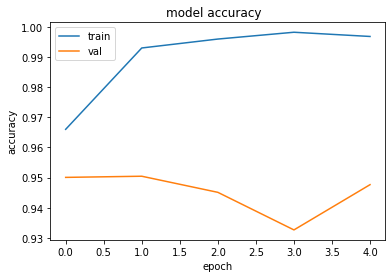

In [29]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'] )
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

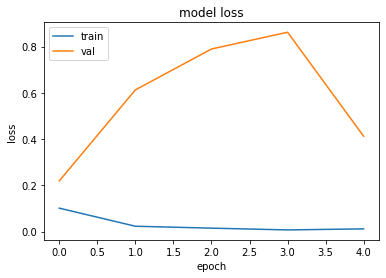

In [30]:
# summarize history for loss
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation of the model

In [32]:
# Evaluate Model Performance
preds = model.evaluate_generator(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Loss = 1.3418595790863037
Test Accuracy = 0.5713125467300415


# Using Transfer Learning 

In [38]:
# ImageDataGenerator for training pictures with data augmentation
eff_train_datagen = ImageDataGenerator (
            preprocessing_function=preprocess_input,
            rescale=1./255,
            horizontal_flip = True, 
            validation_split = 0.2, # Split into Train/Validation
            featurewise_center = False,  # set input mean to 0 over the dataset
            samplewise_center = False,  # set each sample mean to 0
            featurewise_std_normalization = False,  # divide inputs by std of the dataset
            samplewise_std_normalization = False,  # divide each input by its std
            zca_whitening = False,  # apply ZCA whitening
            rotation_range = 40,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.2, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range = 0.2,  # randomly shift images vertically (fraction of total height)
            vertical_flip = False,  # randomly flip images
            shear_range=0.2,
            fill_mode='nearest')

In [40]:
# Train/Validation Generator using Image Augmentation
eff_train_generator = eff_train_datagen.flow_from_directory(
                                                            train_path,
                                                            target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                            subset="training",
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True,
                                                            classes = ('Fire','No_Fire')
                                                            )

eff_validation_generator = eff_train_datagen.flow_from_directory(
                                                            train_path,
                                                            target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                            subset="validation",
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True,
                                                            classes = ('Fire','No_Fire')
                                                        )



Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


{'Fire': 0, 'No_Fire': 1}
{'Fire': 0, 'No_Fire': 1}


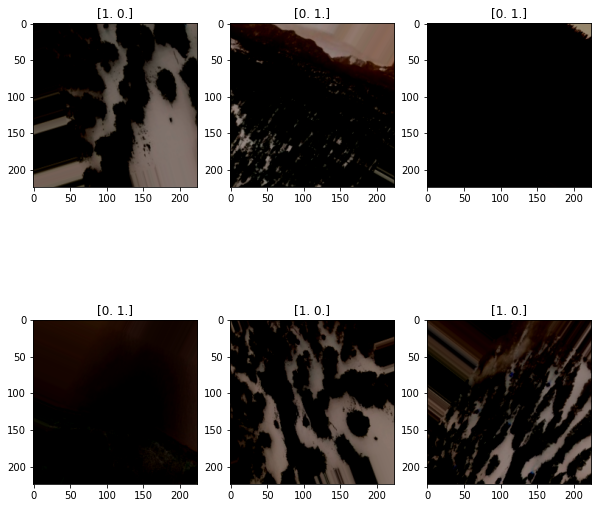

In [51]:
# Plot the random images
fig , axs = plt.subplots(2,3 ,figsize = (10,10))
axs[0][0].imshow(eff_train_generator[0][0][12])
axs[0][0].set_title(eff_train_generator[0][1][12])
axs[0][1].imshow(eff_train_generator[0][0][1])
axs[0][1].set_title(eff_train_generator[0][1][1])
axs[0][2].imshow(eff_train_generator[0][0][14])
axs[0][2].set_title(eff_train_generator[0][1][14])
axs[1][0].imshow(eff_train_generator[0][0][17])
axs[1][0].set_title(eff_train_generator[0][1][17])
axs[1][1].imshow(eff_train_generator[0][0][19])
axs[1][1].set_title(eff_train_generator[0][1][19])
axs[1][2].imshow(eff_train_generator[0][0][3])
axs[1][2].set_title(eff_train_generator[0][1][3])

#Title of 0.0 refers to Fire
#1.0 refers to NoFire
print(eff_train_generator.class_indices)
print(eff_validation_generator.class_indices)

In [34]:
# EfficientNet Model Summary
efnb0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=2)

effmodel = Sequential()
effmodel.add(efnb0)
effmodel.add(GlobalAveragePooling2D())
effmodel.add(Dropout(0.5))
effmodel.add(Dense(2, activation='softmax'))
effmodel.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [35]:
#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

In [36]:
# Compilation of model
effmodel.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['binary_accuracy']
)

In [41]:
eff_train_steps = eff_train_generator.n // eff_train_generator.batch_size
eff_valid_steps = eff_validation_generator.n // eff_validation_generator.batch_size

In [34]:
# Fit data to model
eff_history = effmodel.fit_generator(
                            eff_train_generator,
                            steps_per_epoch=eff_train_steps,
                            epochs = 10,
                            validation_data = eff_validation_generator,
                            validation_steps=eff_valid_steps,
                            verbose=1,
                            callbacks=[early_stop, rlrop]
                )

Epoch 1/10
984/984 [==============================] - 652s 654ms/step - loss: 0.0648 - binary_accuracy: 0.9762 - val_loss: 0.0308 - val_binary_accuracy: 0.9892
Epoch 2/10
984/984 [==============================] - 563s 572ms/step - loss: 0.0199 - binary_accuracy: 0.9933 - val_loss: 0.2081 - val_binary_accuracy: 0.9333
Epoch 3/10
984/984 [==============================] - 573s 582ms/step - loss: 0.0192 - binary_accuracy: 0.9931 - val_loss: 0.0518 - val_binary_accuracy: 0.9850
Epoch 4/10
984/984 [==============================] - 582s 591ms/step - loss: 0.0174 - binary_accuracy: 0.9936 - val_loss: 0.0424 - val_binary_accuracy: 0.9879
Epoch 5/10
984/984 [==============================] - 545s 554ms/step - loss: 0.0154 - binary_accuracy: 0.9948 - val_loss: 0.1611 - val_binary_accuracy: 0.9640
Epoch 6/10
984/984 [==============================] - 542s 550ms/step - loss: 0.0140 - binary_accuracy: 0.9951 - val_loss: 0.0352 - val_binary_accuracy: 0.9893

Epoch 00006: ReduceLROnPlateau reducing

In [35]:
#saving the trained model weights as data file in .h5 format
effmodel.save_weights("efficientnetb0_weights.h5")

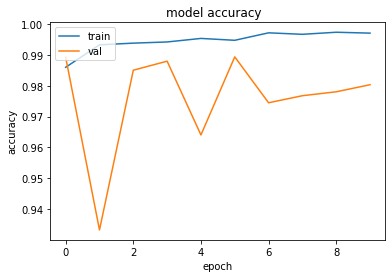

In [36]:
# summarize history for accuracy
plt.plot(eff_history.history['binary_accuracy'] )
plt.plot(eff_history.history['val_binary_accuracy'])
plt.title('model accuracy  ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

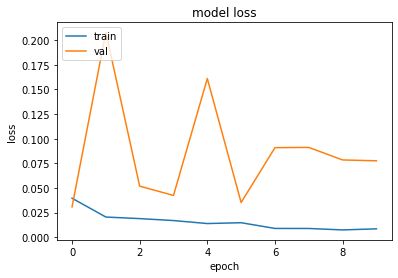

In [37]:
# summarize history for loss
plt.plot(eff_history.history['loss'] )
plt.plot(eff_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation of the model

In [38]:
# Training Accuracy
train_score = effmodel.evaluate_generator(generator = eff_train_generator, verbose = 1)
print("Train accuracy : {:.2f} %".format(train_score[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


985/985 [==============================] - 376s 382ms/step - loss: 0.0056 - binary_accuracy: 0.9977
Train accuracy : 99.77 %


In [39]:
# Validation Accuracy
valid_loss, valid_accuracy = effmodel.evaluate_generator(generator = eff_validation_generator, verbose = 1)
print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

247/247 [==============================] - 94s 382ms/step - loss: 0.0785 - binary_accuracy: 0.9806
Validation Accuracy:  98.06 %


In [43]:
# Using Test Data
eff_test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
                                  rescale=1/255,
                                    validation_split=0.10,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest'
)

eff_test_generator = eff_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    classes = ('Fire','No_Fire')
)

Found 8617 images belonging to 2 classes.


In [47]:
# Test Accuracy
test_score = effmodel.evaluate_generator(generator = eff_test_generator,verbose=1)
print("Test accuracy : {:.2f} %".format(test_score[1]*100))

270/270 [==============================] - 107s 396ms/step - loss: 0.7618 - binary_accuracy: 0.7578
Test accuracy : 75.78 %


In [46]:
eff_test_steps = eff_test_generator.n // eff_test_generator.batch_size

In [44]:
# Evaluation of the model
effpreds = effmodel.predict_generator(
    generator = eff_test_generator,
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


270/270 [==============================] - 105s 384ms/step


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3694    1443]
 [613    2867]]


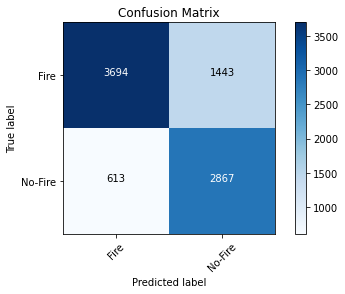

In [ ]:
#Confusion Matrix
test_labels = eff_test_generator.classes
cm = confusion_matrix(test_labels, effpreds.argmax(axis=1))
cm_plot_labels = ['Fire','No-Fire']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')